In [63]:
import os
import pickle
import numpy as np
import pandas as pd
from scipy import signal
import matplotlib.pyplot as plt

import lib_data_filter as dafi
import lib_data_process as dapr

In [64]:
C = 299792458 # m/s
FREQUENCY_GPS_L1 = 1575.42 * 10**6
WAVELENTH_GPS_S1 = C/FREQUENCY_GPS_L1

FREQUENCY_GPS_L2 = 1227.6 * 10**6
WAVELENTH_GPS_S2 = C/FREQUENCY_GPS_L2

FREQUENCY_GPS_L5 = 1176.45 * 10**6
WAVELENTH_GPS_S5 = C/FREQUENCY_GPS_L5

# Glonass
FREQUENCY_GLONASS_L1 = 1602 * 10**6
WAVELENTH_GLONASS_S1 = C/FREQUENCY_GLONASS_L1

FREQUENCY_GLONASS_L2 = 1246 * 10**6
WAVELENTH_GLONASS_S2 = C/FREQUENCY_GLONASS_L2

# Galileo
FREQUENCY_GALILEO_L5 = 1176.45 * 10**6
WAVELENTH_GALILEO_S5 = C/FREQUENCY_GALILEO_L5

FREQUENCY_GALILEO_L6 = 1278.7 * 10**6
WAVELENTH_GALILEO_S6 = C/FREQUENCY_GALILEO_L6

FREQUENCY_GALILEO_L7 = 1207.140 * 10**6
WAVELENTH_GALILEO_S7 = C/FREQUENCY_GALILEO_L7

FREQUENCY_GALILEO_L8 = 1191.795 * 10**6
WAVELENTH_GALILEO_S8 = C/FREQUENCY_GALILEO_L8

In [65]:
glonass_list = {'14':-7,'15':0,'10':-7,'20':2,'19':3,'13':-2,\
                '12':-1,'01':1,'06':-4,'05':1,'22':-3,'23':3,\
                '24':2,'16':-1,'04':6,'08':6,'03':5,'07':5,\
                '02':-4,'18':-3,'21':4,'09':-2,'17':4,'11':0}

In [66]:
# main_path = os.path.abspath('../data/20220811/2/')
# main_path = os.path.abspath('../data/20221004/2/')
# main_path = os.path.abspath('../data/20230216/2/')
main_path = os.path.abspath('../data/20230216/2_rotate/')
azimut_mask = [270,330]
elevation_mask = [5,30]
carrier = 'L1'

In [67]:
data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
            elevation_mask=elevation_mask,trigger='snr1')

In [68]:
data_dict

{'G26':                           time   azimut  elevation   snr1
 0    2023-02-16 14:13:30+00:00  290.774     19.452  49.15
 1    2023-02-16 14:13:31+00:00  290.777     19.458  49.00
 2    2023-02-16 14:13:32+00:00  290.780     19.465  48.90
 3    2023-02-16 14:13:33+00:00  290.783     19.471  48.75
 4    2023-02-16 14:13:34+00:00  290.786     19.477  48.65
 ...                        ...      ...        ...    ...
 1589 2023-02-16 14:39:59+00:00  294.939     29.968  50.00
 1590 2023-02-16 14:40:00+00:00  294.941     29.974  50.15
 1591 2023-02-16 14:40:01+00:00  294.943     29.981  50.35
 1592 2023-02-16 14:40:02+00:00  294.946     29.988  50.55
 1593 2023-02-16 14:40:03+00:00  294.948     29.995  50.60
 
 [1594 rows x 4 columns],
 'G04':                           time   azimut  elevation   snr1
 2688 2023-02-16 14:58:18+00:00  329.995      7.077  50.05
 2689 2023-02-16 14:58:19+00:00  329.989      7.078  50.00
 2690 2023-02-16 14:58:20+00:00  329.983      7.079  50.00
 2691 2023-02-

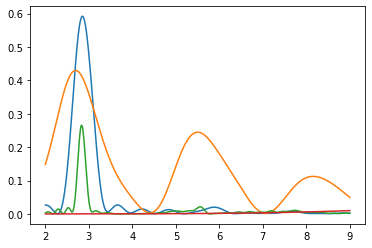

In [69]:
# snr1 gps
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'G':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr1]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S1).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power: 
    plt.plot(frequency,power[satellite])

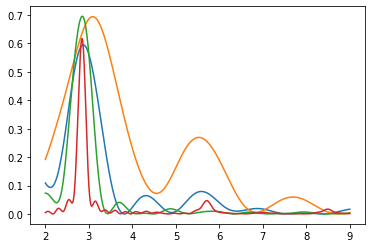

In [70]:
# glonass snr1
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'R':
        pnr = satellite[1:]
        channel = glonass_list[pnr]
        frequency_glo = FREQUENCY_GLONASS_L1 + channel * 0.5625 * 10**6
        wavelength = C / frequency_glo
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr1]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / wavelength).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power: 
    plt.plot(frequency,power[satellite])

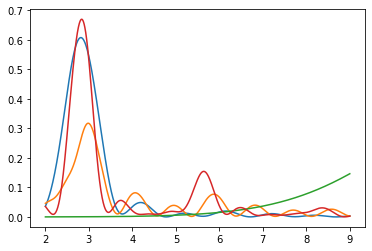

In [71]:
# galileo snr1
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'E':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr1]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S1).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power: 
    plt.plot(frequency,power[satellite])

In [72]:
data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
            elevation_mask=elevation_mask,trigger='snr2')

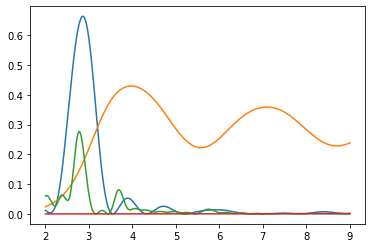

In [73]:
# gps snr2
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'G':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr2]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S2).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power:
    plt.plot(frequency,power[satellite])

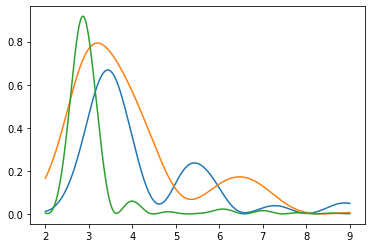

In [74]:
# glonass snr2
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'R':
        pnr = satellite[1:]
        channel = glonass_list[pnr]
        frequency_glo = FREQUENCY_GLONASS_L2 + channel * 0.4375 * 10**6
        wavelength = C / frequency_glo
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr2]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / wavelength).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power: 
    plt.plot(frequency,power[satellite])

In [75]:
data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
            elevation_mask=elevation_mask,trigger='snr5')

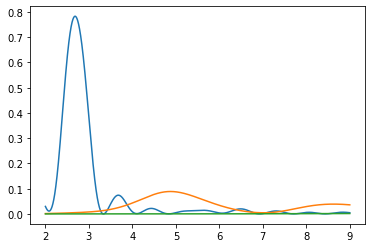

In [76]:
# gps snr5
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'G':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr5]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S2).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power:
    plt.plot(frequency,power[satellite])

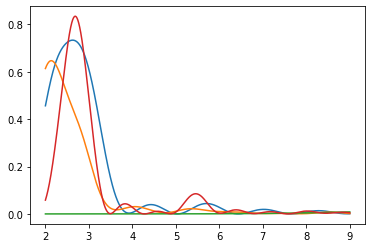

In [77]:
# galileo snr5
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'E':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr5]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S2).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power:
    plt.plot(frequency,power[satellite])

In [78]:
data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
            elevation_mask=elevation_mask,trigger='snr7')

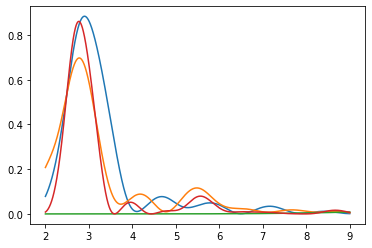

In [79]:
# galileo snr7
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'E':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr7]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S2).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power:
    plt.plot(frequency,power[satellite])

In [80]:
data_dict = dafi.clean_data(main_path,azimut_mask=azimut_mask,\
            elevation_mask=elevation_mask,trigger='snr8')

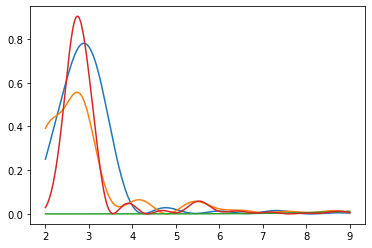

In [81]:
# galileo snr8
frequency = np.arange(2,9,0.001)
power = {}
for satellite in data_dict:
    if satellite[0] == 'E':
        elevation = np.array([data_dict[satellite].elevation]).T
        snr1 = np.array([data_dict[satellite].snr8]).T
        design_matrix = np.concatenate((elevation**2,elevation,\
                    np.ones((elevation.size,1))),axis=1)
        para = np.dot(np.linalg.solve(np.dot(design_matrix.T,design_matrix),\
                        design_matrix.T),snr1)
        snr_ref = snr1 - (elevation**2 * para[0,0] + \
                        para[1,0]*elevation + para[2,0])
        x_data = (np.sin(elevation.T*np.pi/180) * 4 * np.pi / WAVELENTH_GPS_S2).ravel()
        y_data = snr_ref.ravel()
        power[satellite] = signal.lombscargle(x_data,y_data,frequency,normalize=True)
for satellite in power:
    plt.plot(frequency,power[satellite])